# **Predicting Parole Violators**

In many criminal justice systems around the world, inmates deemed not to be a threat to society are released from prison under the parole system prior to completing their sentences. They are still considered to be serving their sentences while on parole, and they can be returned to prison if they violate the terms of their parole.


Parole boards are charged with identifying which inmates are good candidates for release on parole. They seek to release inmates who will not commit additional crimes after release. In this problem, we will build and validate a model that predicts if an inmate will violate the terms of his or her parole. Such a model could be useful to a parole board when deciding to approve or deny an application for parole.


The file Parole.csv contains data from 2004 on parolees who served no more than 6 months in prison and whose maximum sentence for all charges did not exceed 18 months. All parolees in the dataset either successfully completed the term of their parole during 2004 or violated the terms of their parole in 2004. The variables are described in Table 22.5.

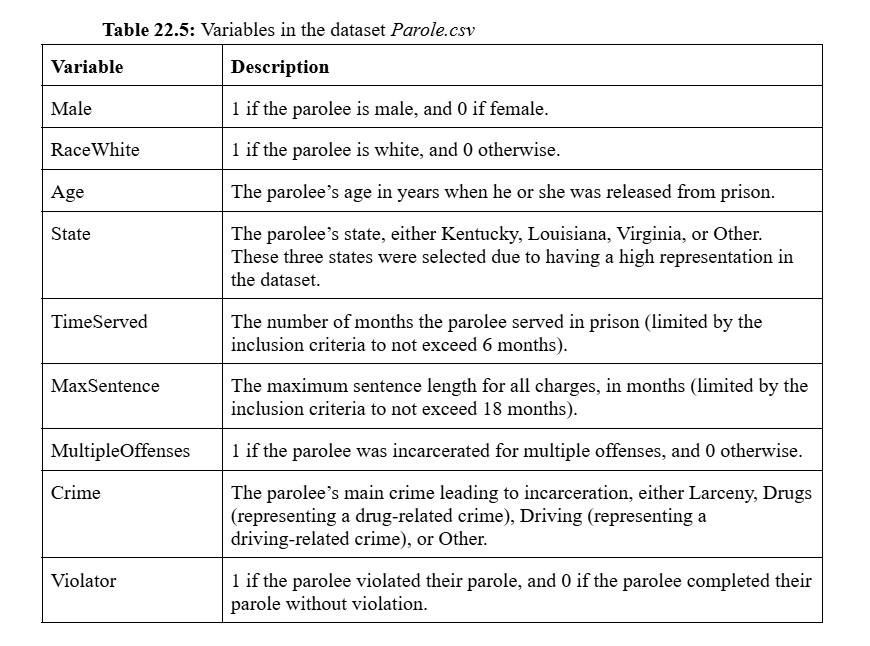

Using this dataset, answer the following questions.

**a) How many parolees do we have data for? Of the parolees that we have data for, what percentage violated the terms of their parole?**

* Number of parolees in the dataset: **675**
* Percentage who violated parole: **11.56%**


In [16]:
import pandas as pd

df = pd.read_csv("/content/Parole-2.csv")
display(df.head())

num_parolees = len(df)

percent_violators = df["Violator"].mean() * 100

print(f"Number of parolees in the dataset: {num_parolees}")
print(f"Percentage who violated parole: {percent_violators:.2f}%")

,Male,RaceWhite,Age,State,TimeServed,MaxSentence,MultipleOffenses,Crime,Violator
0,1,1,33.2,Other,5.5,18,0,Driving,0
1,0,1,39.7,Other,5.4,12,0,Drugs,0
2,1,0,29.5,Other,5.6,12,0,Drugs,0
3,1,1,22.4,Other,5.7,18,0,Other,0
4,1,0,21.6,Other,5.4,12,0,Other,0


Number of parolees in the dataset: 675
Percentage who violated parole: 11.56%




---



**b)Randomly split the data into a training set and a testing set, putting 70% of the data in the training set. Then, build a logistic regression model to predict the variable Violator using all of the other variables as independent variables. You should use the training dataset to build the model.**

**i) Describe your resulting model. Which variables are significant in your model?**

I built a logistic regression model using all predictors (demographics, sentence characteristics, state, and crime type). To assess statistical significance, I refit the model using statsmodels.logit (sm.logit), which provides p-values for each coefficient.

Using a significance threshold of p < 0.05, the following variables were statistically significant predictors of parole violation:

* State_Virginia (p-value = 3.042199e-09): a strong coefficient, indicating that parolees released in Virginia have much lower odds of violating parole compared to the reference state (Kentucky).
* MultipleOffenses (p-value = 2.589543e-06): a strong coefficient, meaning parolees with multiple offenses are significantly more likely to violate parole.
* RaceWhite (p-value = 1.964864e-02 or 0.01964864): a strong coefficient (but not as strong as the previous variables p-values), indicating the White parolees are less likely to violate parole controlling for other variables.

All other predictors (Male, Age, TimeServed, MaxSentence, State_Louisiana, State_Other, and the Crime categories) had p-values above 0.05 and were therefore not statistically significant.



In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

df = pd.read_csv("Parole-2.csv")

df_encoded = pd.get_dummies(df, columns=['State', 'Crime'], drop_first=True)

X = df_encoded.drop(columns=['Violator'])
y = df_encoded['Violator']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values(by='Coefficient', key=abs, ascending=False)

print("Number of features used:", len(X.columns))
display(coef_df.head(10))


Number of features used: 12


,Feature,Coefficient
8,State_Virginia,-2.609246
5,MultipleOffenses,1.003497
1,RaceWhite,-0.985898
6,State_Louisiana,0.757391
10,Crime_Larceny,0.515146
0,Male,-0.233527
11,Crime_Other,0.201621
3,TimeServed,-0.176522
7,State_Other,0.113545
9,Crime_Drugs,0.089007


In [18]:
import statsmodels.api as sm

X_sm = sm.add_constant(X)

for col in X_sm.columns:
    if X_sm[col].dtype == bool:
        X_sm[col] = X_sm[col].astype(int)

logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

print(result.summary2())

coef_table = pd.DataFrame({
    "Variable": result.params.index,
    "Coefficient": result.params.values,
    "P-Value": result.pvalues.values
}).sort_values(by="P-Value")

display(coef_table)

significant_vars = coef_table[coef_table["P-Value"] < 0.05]
print("\n Statistically Significant Variables (p < 0.05):")
display(significant_vars)

Optimization terminated successfully.
         Current function value: 0.258281
         Iterations 8
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Violator         Pseudo R-squared: 0.278     
Date:               2025-11-17 06:12 AIC:              374.6792  
No. Observations:   675              BIC:              433.3705  
Df Model:           12               Log-Likelihood:   -174.34   
Df Residuals:       662              LL-Null:          -241.63   
Converged:          1.0000           LLR p-value:      7.3862e-23
No. Iterations:     8.0000           Scale:            1.0000    
-----------------------------------------------------------------
                   Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-----------------------------------------------------------------
const             -2.4873   1.1547 -2.1541 0.0312 -4.7504 -0.2242
Male               0.2706   0.3705  0.7304 0.4651 -0.4556  0.9968


,Variable,Coefficient,P-Value
9,State_Virginia,-3.489241,3.042199e-09
6,MultipleOffenses,1.531547,2.589543e-06
2,RaceWhite,-0.757252,1.964864e-02
0,const,-2.487286,3.123092e-02
7,State_Louisiana,0.685413,1.496558e-01
5,MaxSentence,0.053293,2.239571e-01
11,Crime_Larceny,0.494705,3.974793e-01
4,TimeServed,-0.076548,4.418448e-01
1,Male,0.270624,4.651388e-01
8,State_Other,-0.208399,6.176915e-01



 Statistically Significant Variables (p < 0.05):


,Variable,Coefficient,P-Value
9,State_Virginia,-3.489241,3.042199e-09
6,MultipleOffenses,1.531547,2.589543e-06
2,RaceWhite,-0.757252,1.964864e-02
0,const,-2.487286,3.123092e-02


                                                            

---



**ii) Consider a parolee who is male, of white race, aged 50 years at prison release, from the state of Maryland, served 3 months, had a maximum sentence of 12 months, did not commit multiple offenses, and committed a larceny. According to your model, what is the probability that this individual is a violator? (HINT: You should use the coefficients of your model and the Logistic Response Function to solve this problem.)**

According to this model, the probability that this individual will violate their parole is a 9.36% chance.

In [19]:
import pandas as pd

df_encoded = pd.get_dummies(df, columns=['State', 'Crime'], drop_first=True)

X = df_encoded.drop(columns=['Violator'])
y = df_encoded['Violator']

X = X.astype(int)

X_sm = sm.add_constant(X)
logit_model = sm.Logit(y, X_sm)
result = logit_model.fit()

new_data = {col: 0 for col in X.columns}

new_data['Male'] = 1
new_data['RaceWhite'] = 1
new_data['Age'] = 50
new_data['TimeServed'] = 3
new_data['MaxSentence'] = 12
new_data['MultipleOffenses'] = 0
# state and crime dummies stay 0 because:
# Maryland --> State Other
# Larceny --> reference crime

new_df = pd.DataFrame([new_data])

new_df_sm = sm.add_constant(new_df, has_constant='add')

predicted_prob = float(result.predict(new_df_sm)[0])

print("Predicted probability of violating parole:", predicted_prob)

Optimization terminated successfully.
         Current function value: 0.258215
         Iterations 8
Predicted probability of violating parole: 0.09363270430057734




---



**iii) Now compute the model’s predicted probabilities for parolees in the testing set. Then create a confusion matrix for the test set using a threshold of 0.5. What is the model’s false positive rate on the test set? False negative rate? Overall accuracy?**

The confusion matrix is:

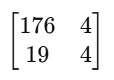

The model's false positive rate on the test set is 0.2222, the false negative rate is 0.8260, and the overall accuracy of the test data set is 0.8866.

These results indicate that while the model has high overall accuracy at 88.66%, it makes a large number of false negative errors, meaning it frequently predicts that a violator will not violate parole. The false positive rate, on the other hand, is pretty low.

In [20]:
from sklearn.metrics import confusion_matrix, accuracy_score

y_prob_test = model.predict_proba(X_test)[:, 1]

y_pred_test = (y_prob_test >= 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_test)
tn, fp, fn, tp = cm.ravel()

print("Confusion Matrix:")
print(cm)

fpr = fp / (fp + tn)

fnr = fn / (fn + tp)

accuracy = accuracy_score(y_test, y_pred_test)

print("\nFalse Positive Rate:", fpr)
print("False Negative Rate:", fnr)
print("Overall Accuracy:", accuracy)

Confusion Matrix:
[[176   4]
 [ 19   4]]

False Positive Rate: 0.022222222222222223
False Negative Rate: 0.8260869565217391
Overall Accuracy: 0.8866995073891626




---



**iv) Compare your accuracy on the test set to a baseline model that predicts every parolee in the test set is a non-violator, regardless of the values of the independent variables. Does your model improve over this simple model?**

The logistic regression model does not improve over the baseline model in terms of accuracy. Both models achieve the same accuracy (86.66%) on the test set.

This indicates that, at a threshold of 0.5, the logistic regression model is essentially making the same predictions as the baseline model, mostly predicting that parolees will not violate parolee.

In [21]:
import numpy as np
from sklearn.metrics import accuracy_score

baseline_pred = np.zeros_like(y_test)
baseline_accuracy = accuracy_score(y_test, baseline_pred)

print("Baseline Accuracy:", baseline_accuracy)
print("Model Accuracy:", accuracy)


Baseline Accuracy: 0.8866995073891626
Model Accuracy: 0.8866995073891626




---



**v) Consider a parole board that might use your model to predict whether parolees will be violators or not. The job of a parole board is to make sure that a prisoner is ready to be released into free society, and therefore parole boards tend to be particularly concerned about releasing prisoners who will violate their parole. Would the parole board be more concerned by false positive errors or false negative errors? How should they adjust their threshold to reflect their error preferences?**

Since the parole board's primary job is to avoid releasing people who will violate parole, the board would be more concerned about false negatives. A false negative means that the model predicts a non-violator but the person is a violator which makes it a dangerous miss becuase a person who should have been denied parole or further reviewed gets released. Because public safety and risk of harm are the key priorities, the cost of a false negative is genearlly much higher than the cost of a false positive. So the board should be favoring reducing false negatives even if that increases false positives. (Although, this is a harsh reality since this means more frequently denying parole.)

To reduce false negatives, I would lower the decision threshold and try 0.3, 0.2, or 0.1 instead of 0.5 and inspect the tradeoff for false negatives and false positives. I would also still try and consider fairness in the collaboration, since lowering the threshold increases denials, they should check the subgroup impacts to avoid disparate harm.



---



**vi) Compute the AUC of the model on the test set, and interpret what the number means in this context. Considering the AUC, the accuracy compared to the baseline model, and what happens when the threshold is adjusted, do you think this model is of value to a parole board? Why or why not?
[Please report accuracy. Recall, F1 score, AUC respectively, the threshold for calculation is 0.5.]**

The AUC of 0.8164 means that if you randomly select one violator and one non-violator, the model will asign a higher risk score to the true violator about 81% of the time. AUC measures ranking ability, not classification accuracy. So even though the model struggles to correctly classify violators at threshold 0.5, it is good at ordering parolees by likelihood of violation.

I think that this model is of value to the parole board if it is used as a risk-ranking tool, not for direct decisions concerning release. If the parole board uses the model to successfully rank individuals by risk, the parole board could lower the threshold to reduce false negatives, use risk scores to prioritize cases for review, and use the model as part of a larger risk-assessment process. When used as a risk-ranking tool rather than a strict classifier, the model can still provide meaningful value by helping identify higher-risk individuals for closer review.


In [22]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(y_test, y_prob_test)
print("AUC:", auc)

AUC: 0.8164251207729468




---



**c) Our goal in this problem has been to predict the outcome of a parole decision, and we used a publicly available dataset of parole releases for predictions. It is always important to evaluate a dataset for possible sources of bias, especially when the dataset only contains a subset of the observations of interest.**

**The Parole.csv dataset contains all individuals released from parole in 2004, either due to completing their parole term or violating the terms of their parole. However, it does not contain parolees who neither violated their parole nor completed their term in 2004, causing non-violators to be underrepresented. This is called selection bias or selecting on the dependent variable, because we used our dependent variable (parole violation) to select only a subset of all relevant parolees to include in our analysis. How could we improve our dataset to best address selection bias?**

To address selection bias, we should expand the dataset to include all parolees released during the study period, not only those who completed or violated their parole in 2004. Parolees who were still serving their parole term at the end of 2004 should also be included. Additionally, the dataset should track each parolee over time and record the time until violation or completion, with those who have not yet reached an outcome treated as right-censored. This would give us a representative sample of the full parolee population and eliminate the problem of selecting on the dependent variable. A more complete dataset of this form would allow for a more unbiased prediction model and potentially more appropriate methods such as survival analysis.